In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/Merged_Disasters(2).csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Perform stratified splitting (70% Train, 15% Validation, 15% Test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

# Display summary
print("\nData Split Summary:\n", split_summary)
print("\nData split completed and saved as CSV files.")


Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

Data split completed and saved as CSV files.


Loading FastText model...
Generating document embeddings...


100%|██████████| 2713/2713 [00:00<00:00, 22255.15it/s]


Original Train class distribution:
 0    10853
1     1804
Name: count, dtype: int64
Original Validation class distribution:
 0    2326
1     386
Name: count, dtype: int64
Original Test class distribution:
 0    2326
1     387
Name: count, dtype: int64
After SMOTE Train class distribution:
 1    10853
0    10853
Name: count, dtype: int64
Train Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     10853
           1       0.94      0.98      0.96     10853

    accuracy                           0.96     21706
   macro avg       0.96      0.96      0.96     21706
weighted avg       0.96      0.96      0.96     21706

Train Accuracy: 0.9565
Train ROC-AUC: 0.9919


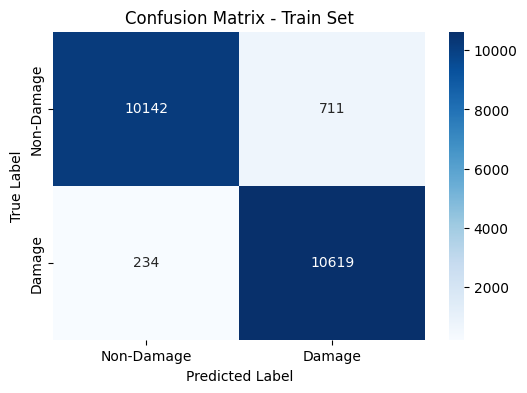

In [ ]:
# ========== Imports ==========
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tqdm import tqdm

# ========== Load FastText Model ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== Load Data ==========
train_path = "/content/train_data.csv"
val_path = "/content/val_data.csv"
test_path = "/content/test_data.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

# ========== Clean and Map Labels ==========
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, val_df, test_df]:
    df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# ========== Function to Create Document Embeddings ==========
def get_avg_embedding(text, model, dim):
    words = text.split()
    embeddings = [model[word] for word in words if word in model]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(dim)

# ========== Generate Embeddings ==========
print("Generating document embeddings...")
X_train = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(train_df['Processed_data'])])
X_val = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(val_df['Processed_data'])])
X_test = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(test_df['Processed_data'])])

y_train = train_df['Binary_class'].values
y_val = val_df['Binary_class'].values
y_test = test_df['Binary_class'].values

# ========== Show Class Distributions ==========
print("Original Train class distribution:\n", pd.Series(y_train).value_counts())
print("Original Validation class distribution:\n", pd.Series(y_val).value_counts())
print("Original Test class distribution:\n", pd.Series(y_test).value_counts())

# ========== Apply SMOTE ==========
smote = SMOTE(sampling_strategy=1, k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE Train class distribution:\n", pd.Series(y_train_smote).value_counts())

# ========== Train Random Forest with Regularized Params ==========
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_smote, y_train_smote)

# ========== Evaluate on Train Set ==========
y_train_pred = rf_model.predict(X_train_smote)
y_train_proba = rf_model.predict_proba(X_train_smote)[:, 1]

print("Train Classification Report:")
print(classification_report(y_train_smote, y_train_pred))
print(f'Train Accuracy: {accuracy_score(y_train_smote, y_train_pred):.4f}')
print(f'Train ROC-AUC: {roc_auc_score(y_train_smote, y_train_proba):.4f}')

# ========== Confusion Matrix - Train ==========
cm_train = confusion_matrix(y_train_smote, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Train Set")
plt.show()
